In [ ]:
# # Google Colab Specific commands
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # # Example: Unzip into the current working directory - since i have a zip in my drive and i want to unzip into my colab env for faster access
!unzip -q "/content/drive/MyDrive/Colab Notebooks/pravin_thesis/0_dataset/11_balanced_class_subfolder_no_label.zip" -d '/content/dataset/'

In [ ]:
!pip install keras_cv rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 68.1 MB/s eta 0:00:00


In [ ]:
# Standard Library Imports
import os
import random
import shutil
import warnings
# Data Analysis and Manipulation
import pandas as pd
import numpy as np
# Image Processing
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import rasterio
from PIL import Image
import PIL
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
# Machine Learning and Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import image_dataset_from_directory
from keras.optimizers import AdamW
import keras_cv
keras.mixed_precision.set_global_policy("mixed_float16")
# Progress Bars
import tqdm
from tqdm.auto import trange, tqdm
# Evaluation Metrics
import sklearn
from sklearn.metrics import precision_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

Using TensorFlow backend


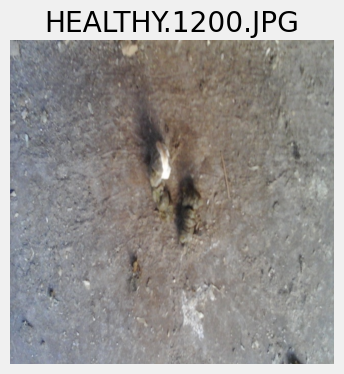

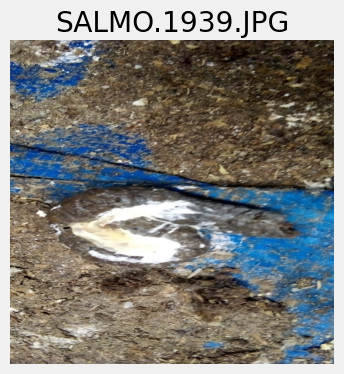

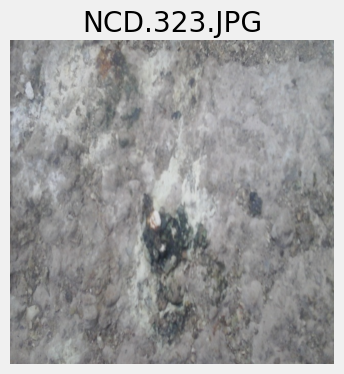

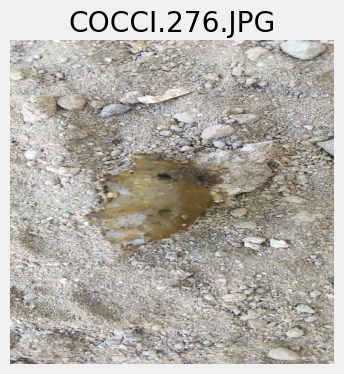

In [ ]:
def show_disease_sample_images(base_dir:str ,name: str):
    # Get a list of all files in the disease_class_dir directory
    disease_class_dir = base_dir+name
    files = os.listdir(disease_class_dir)

    # Pick a random image from the files
    random_image_name = random.choice(files)

    # Read the image using matplotlib.image
    img_path = os.path.join(disease_class_dir, random_image_name)
    img = mpimg.imread(img_path)

    # Plot the image
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(img)
    ax.grid(False)
    ax.axis('off')  # Turn off axis labels

    # Set title
    ax.set_title(img_path.split('/')[-1].upper())

    # Display the plot
    plt.show()

base_dir = '/content/dataset/'
class_names = os.listdir(base_dir)
for class_name in class_names:
  show_disease_sample_images(base_dir, class_name)

In [ ]:
IMAGE_SIZE = (260,260) #For EfficentNetV2B2
BATCH_SIZE = 32
COLOR_MODE = "rgb"
SHUFFLE = True
TRAIN_PATH = "/content/dataset/"
SEED = 4224
AUTOTUNE = tf.data.experimental.AUTOTUNE
NUM_CLASSES = 4
NUM_EPOCHS = 50
INITIAL_LEARNING_RATE = 0.0001

In [ ]:
IMAGE_SIZE

(260, 260)

In [ ]:
def load_batches(imgsz: tuple, bsz: int, clr: str, shuffle: bool, path_: str, seed: int):
    try:
        batch_1, batch_2 = image_dataset_from_directory(
            image_size=imgsz,
            directory=path_,
            color_mode=clr,
            shuffle=shuffle,
            validation_split=0.2,
            subset="both",
            seed=seed,
            labels="inferred",
            batch_size=bsz,
            class_names=None,
            interpolation="bilinear",
            crop_to_aspect_ratio=True
        )
        return batch_1, batch_2
    except ValueError as e:
        print(f"Error loading data from directory {path_}: {str(e)}")
        return None, None

train_batch, valid_batch = load_batches(imgsz=IMAGE_SIZE, bsz=BATCH_SIZE, clr=COLOR_MODE, shuffle=SHUFFLE, path_=TRAIN_PATH, seed=SEED)
if train_batch is None:
    print("Failed to load training batch. Check directory and file formats.")


Found 11240 files belonging to 4 classes.
Using 8992 files for training.
Using 2248 files for validation.


In [ ]:
train_batch.class_names

['cocci', 'healthy', 'ncd', 'salmo']

In [ ]:
def rescale_imgs(img_, lbl_):
    img_ = tf.cast(img_, tf.float32)
    return img_/255.0, lbl_

train_batch = train_batch.map(rescale_imgs, num_parallel_calls = tf.data.AUTOTUNE)
valid_batch = valid_batch.map(rescale_imgs, num_parallel_calls = tf.data.AUTOTUNE)

In [ ]:
def augment_img(img_, lbl_):
    image = tf.image.random_flip_left_right(img_)
    image = tf.image.central_crop(image, 0.85)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.5, 2.0)
    return tf.cast(image, tf.float32), lbl_

train_batch = train_batch.map(augment_img, tf.data.AUTOTUNE)
train_batch = train_batch.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
valid_batch = valid_batch.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
len(valid_batch) * 32

2272

In [ ]:
def val_batch_class_distribution(valid_batch):
    images = list()
    labels = list()

    for img, lbl in valid_batch.unbatch():
        images.append(img)
        if lbl == 0:
            labels.append("Coccidiosis")
        elif lbl == 1:
            labels.append("Healthy")
        elif lbl == 2:
            labels.append("Newcastle Disease")
        else:
            labels.append("Salmo")
    images = np.array(images)
    labels = np.array(labels)

    print(f'Coccidiosis Percentage: {np.mean(labels == "Coccidiosis")}')
    print(f'Healthy Percentage: {np.mean(labels == "Healthy")}')
    print(f'Newcastle Disease Percentage: {np.mean(labels == "Newcastle Disease")}')
    print(f'Salmo Percentage: {np.mean(labels == "Salmo")}')
    return labels

labels_ = val_batch_class_distribution(valid_batch)

Coccidiosis Percentage: 0.2611209964412811
Healthy Percentage: 0.24332740213523132
Newcastle Disease Percentage: 0.2557829181494662
Salmo Percentage: 0.23976868327402134


In [ ]:
weights_ = class_weight.compute_class_weight("balanced", classes = ['coccidiosis', 'healthy', 'newcastle disease', 'salmo'], y = [i.lower() for i in labels_])
weight_dict = {}
for i, j in enumerate(weights_):
    weight_dict[i] = j
weight_dict

{0: 0.9574105621805792,
 1: 1.0274223034734917,
 2: 0.9773913043478261,
 3: 1.0426716141001855}

In [ ]:
def create_efficient_model():
  # LINK: https://keras.io/api/keras_cv/models/backbones/efficientnet_v2/#efficientnetv2b2backbone-class
    backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
        # TODO: try EfficientNetV2B2 later: efficientnetv2_b2_imagenet, efficientnetv2_b2
        "efficientnetv2_b0_imagenet",
        activation="relu",
        # the suitable input shape: https://www.kaggle.com/models/google/efficientnet-v2
        # 260,260 is recommneded
        input_shape=(260, 260, 3),
        include_rescaling = False,
        load_weights = True
    )
    # TODO: Comment the below line if performing bad.
    # backbone.trainable = False

    model = keras_cv.models.ImageClassifier(
        backbone=backbone,
        num_classes=NUM_CLASSES,
        activation = "softmax",
        name = "KerasCV_efficientnet"
    )
    # TODO: Uncomment the below line if performing bad.
    model.trainable = True

    initial_learning_rate = INITIAL_LEARNING_RATE
    optimizer = keras.optimizers.AdamW(learning_rate = initial_learning_rate)

    model.compile(optimizer = optimizer,
                  loss = keras.losses.SparseCategoricalCrossentropy(),
                  metrics = ["accuracy"])
    return model

In [ ]:
efficient_model = create_efficient_model()

100%|██████████| 1.79k/1.79k [00:00<00:00, 1.85MB/s]
100%|██████████| 23.1M/23.1M [00:01<00:00, 18.9MB/s]
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


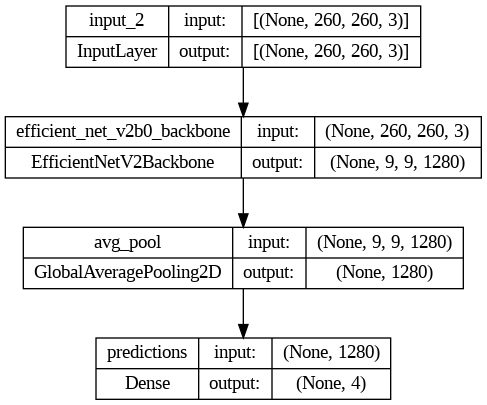

In [ ]:
keras.utils.plot_model(efficient_model, to_file = "efficientnet_model_architecture.png", show_shapes = True)

In [ ]:
efficient_model.summary()

Model: "KerasCV_efficientnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 260, 260, 3)]     0         
                                                                 
 efficient_net_v2b0_backbon  (None, 9, 9, 1280)        5919312   
 e (EfficientNetV2Backbone)                                      
                                                                 
 avg_pool (GlobalAveragePoo  (None, 1280)              0         
 ling2D)                                                         
                                                                 
 predictions (Dense)         (None, 4)                 5124      
                                                                 
Total params: 5924436 (22.60 MB)
Trainable params: 5863828 (22.37 MB)
Non-trainable params: 60608 (236.75 KB)
_________________________________________________________________


In [ ]:
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, precision_score, accuracy_score, f1_score, recall_score

In [ ]:
def fit_model_and_save_logs(model, name:str, train_, valid_):
    # Initialize metrics list
    metrics = []

    # Extract true labels from the validation dataset
    true_values = [y for x, y in valid_.unbatch()]

    # Define callbacks
    es_cb = EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        # TODO: What are different modes?
        mode='auto',
        restore_best_weights=True
    )
    lr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        # TODO: what is this patience and difference between both patience
        patience=5,
        min_lr=0.0001,
        verbose=1
    )
    checkpoint_cb = ModelCheckpoint(
        filepath=f"{name}_best_model.h5",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    csv_log = keras.callbacks.CSVLogger(
        filename = f"{name}_logs.csv",
        separator = ","
    )

    model.fit(
        train_,
        validation_data = valid_,
        callbacks = [es_cb, lr_cb, csv_log, checkpoint_cb],
        verbose = 2,
        epochs = NUM_EPOCHS,
        # Added inverse class weight
        class_weight=weight_dict
    )

    # Convert history to a DataFrame for easier plotting
    history_df = pd.DataFrame(model.history.history)
    # Plot accuracy and loss
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (17,6), sharey = False)
    history_df[["accuracy", "val_accuracy"]].plot(ax = ax[0], title = "Accuracy vs Validation Accuracy", lw = 2)
    history_df[["loss", "val_loss"]].plot(ax = ax[1], title = "Loss vs Validation Loss", lw = 1.7)
    plt.savefig(f"{name}_train_val.png")

    # Predict on validation data
    preds = model.predict(valid_, verbose = 2)
    preds = np.argmax(preds, axis  = 1)

    # Calculate metrics
    accuracy_ = accuracy_score(true_values, preds) * 100
    precision_ = precision_score(true_values, preds, average="weighted") * 100
    f1_ = f1_score(true_values, preds, average="weighted") * 100
    recall_ = recall_score(true_values, preds, average="weighted") * 100
    metrics.extend([accuracy_, precision_, f1_, recall_])

    # Classification report
    cr = classification_report(true_values, preds, output_dict = True)
    cr = pd.DataFrame(cr)
    cr.columns = ['coccidiosis', 'healthy', 'newcastle disease', 'salmo', 'accuracy', 'macro avg', 'weighted avg']
    cr = cr.T
    cr.to_csv(f"{name}_classification_report.csv", index = 1)

    fig, ax = plt.subplots(1,1,figsize = (10,10))
    ConfusionMatrixDisplay.from_predictions(true_values, preds, cmap = "Blues", display_labels = ['coccidiosis', 'healthy', 'newcastle disease', 'salmo'], ax = ax)
    plt.title(f"{name} Confusion Matrix")
    plt.savefig(f"{name}_confusion_matrix.jpg")

    metric_dataframe = pd.DataFrame(
            data = {"metrics": ["Accuracy", "Precision", "F1_Score", "Recall"],
                    "score": metrics,
                    "name": [f"{name}", f"{name}", f"{name}", f"{name}"]}
    )
    return metric_dataframe

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.88835, saving model to efficientnet_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


281/281 - 97s - loss: 0.7582 - accuracy: 0.7395 - val_loss: 0.3012 - val_accuracy: 0.8883 - lr: 1.0000e-04 - 97s/epoch - 344ms/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.88835 to 0.93194, saving model to efficientnet_best_model.h5
281/281 - 38s - loss: 0.2099 - accuracy: 0.9342 - val_loss: 0.1928 - val_accuracy: 0.9319 - lr: 1.0000e-04 - 38s/epoch - 136ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.93194 to 0.93594, saving model to efficientnet_best_model.h5
281/281 - 38s - loss: 0.1304 - accuracy: 0.9592 - val_loss: 0.1701 - val_accuracy: 0.9359 - lr: 1.0000e-04 - 38s/epoch - 136ms/step
Epoch 4/50

Epoch 4: val_accuracy improved from 0.93594 to 0.94173, saving model to efficientnet_best_model.h5
281/281 - 38s - loss: 0.0803 - accuracy: 0.9773 - val_loss: 0.1664 - val_accuracy: 0.9417 - lr: 1.0000e-04 - 38s/epoch - 136ms/step
Epoch 5/50

Epoch 5: val_accuracy improved from 0.94173 to 0.94351, saving model to efficientnet_best_model.h5
281/281 - 38s - loss: 0.0608

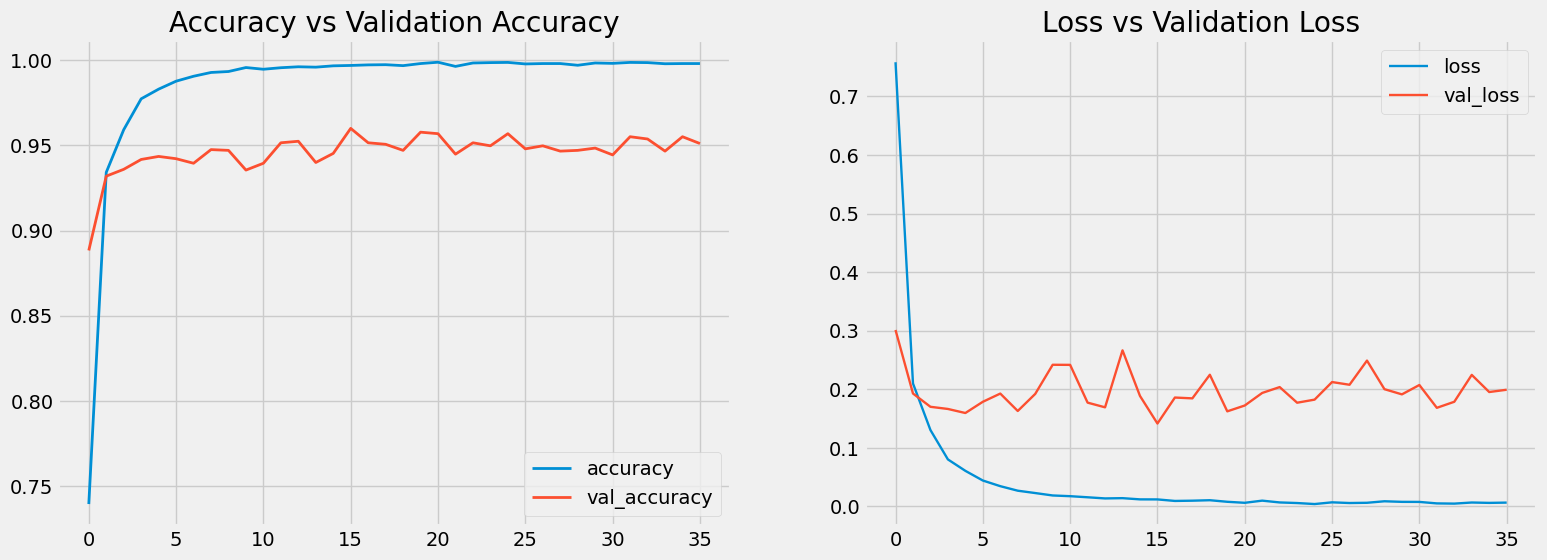

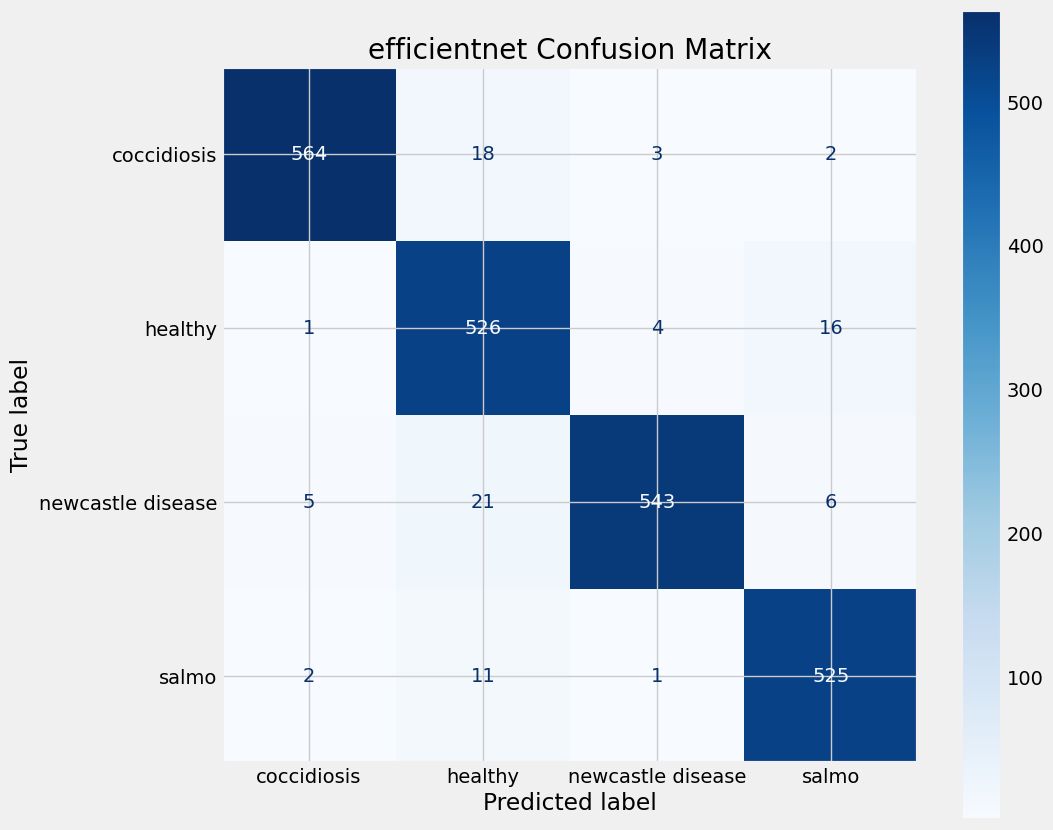

In [ ]:
en_metric_df_1 = fit_model_and_save_logs(efficient_model, "efficientnet", train_batch, valid_batch)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.60454, saving model to efficientnet_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


281/281 - 96s - loss: 1.0093 - accuracy: 0.5688 - val_loss: 0.9427 - val_accuracy: 0.6045 - lr: 1.0000e-04 - 96s/epoch - 341ms/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.60454 to 0.71263, saving model to efficientnet_best_model.h5
281/281 - 36s - loss: 0.7403 - accuracy: 0.7105 - val_loss: 0.7588 - val_accuracy: 0.7126 - lr: 1.0000e-04 - 36s/epoch - 129ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.71263 to 0.75044, saving model to efficientnet_best_model.h5
281/281 - 36s - loss: 0.5855 - accuracy: 0.7781 - val_loss: 0.6691 - val_accuracy: 0.7504 - lr: 1.0000e-04 - 36s/epoch - 130ms/step
Epoch 4/50

Epoch 4: val_accuracy improved from 0.75044 to 0.76290, saving model to efficientnet_best_model.h5
281/281 - 36s - loss: 0.4864 - accuracy: 0.8178 - val_loss: 0.6443 - val_accuracy: 0.7629 - lr: 1.0000e-04 - 36s/epoch - 130ms/step
Epoch 5/50

Epoch 5: val_accuracy improved from 0.76290 to 0.79448, saving model to efficientnet_best_model.h5
281/281 - 37s - loss: 0.4030

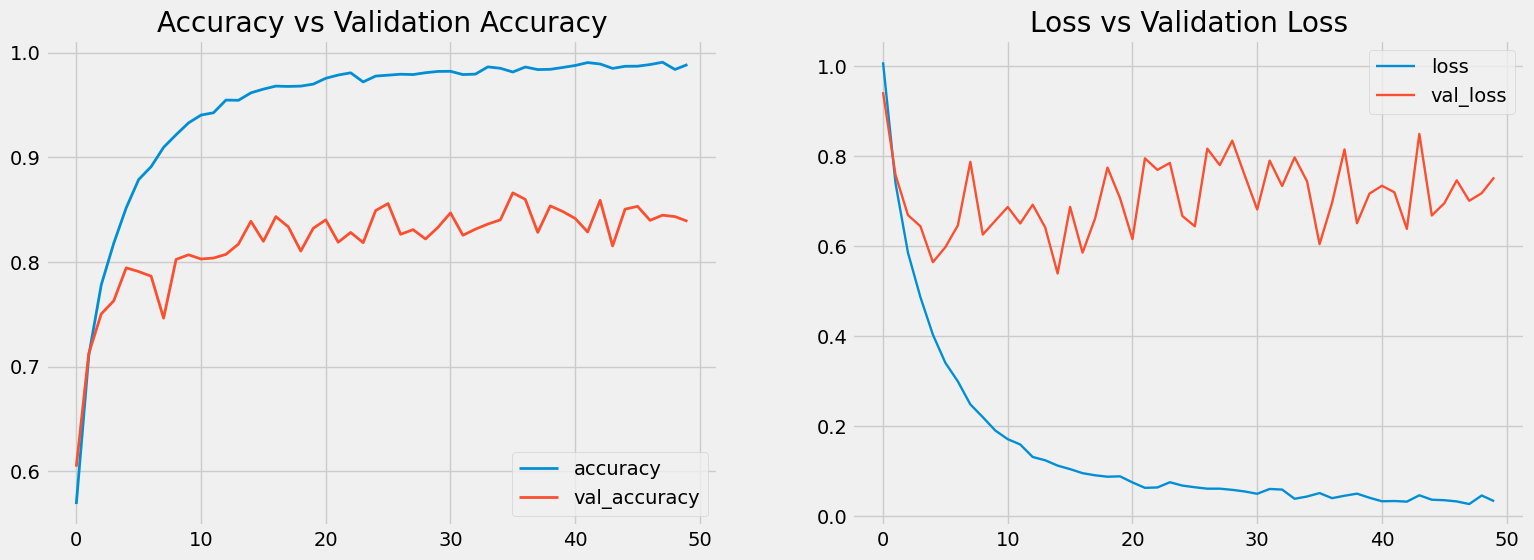

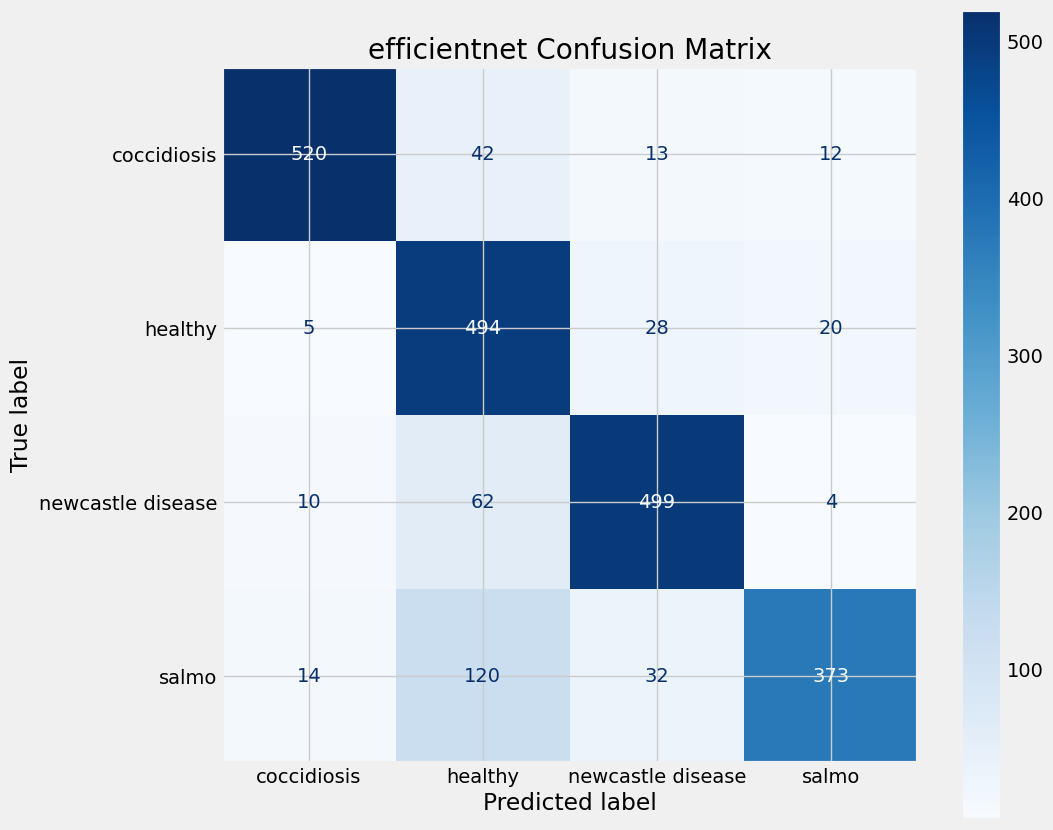

In [ ]:
en_metric_df_2 = fit_model_and_save_logs(efficient_model, "efficientnet", train_batch, valid_batch)
# without imagenet weight and efficientnetv2B0 instead of efficientnetv2B0_imagenet
# It started from a low point and did not converge well even after 50 epochs

In [ ]:
mkdir output

In [ ]:
cp -r './output' '/content/drive/MyDrive/Colab Notebooks/pravin_thesis/2_Image_classification/4_efficientNetV2B2'

In [ ]:
# Load model and predit

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import keras_cv

# Define the custom objects
custom_objects = {
    'EfficientNetV2Backbone': keras_cv.models.EfficientNetV2Backbone,
    'ImageClassifier': keras_cv.models.ImageClassifier,
    'AdamW': AdamW
}

# Load the saved model with custom objects
model = load_model('efficientnet_best_model.h5', custom_objects=custom_objects)

# Load and preprocess the sample image
img_path = './dataset/salmo/salmo.0.jpg'
img = image.load_img(img_path, target_size=IMAGE_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize the image if your model expects normalized images

# Make a prediction
predictions = model.predict(img_array)

# Interpret the prediction (this depends on your model's output format)
predicted_class = np.argmax(predictions, axis=1)
print(f"Predicted class: {predicted_class}")


1/1 [==============================] - 1s 1s/step
Predicted class: [3]
